___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Авторские права принадлежат Pierian Data Inc.</em></center>
<center><em>Для дополнительной информации посетите наш сайт <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# Мультиклассовая Логистическая Регрессия

Студенты часто спрашивают, как выполняется не-бинарная классификация с помощью логистической регрессии. К счастью, сделать это в scikit-learn можно практически точно так же, как и в случае бинарной классификации. Давайте рассмотрим этот процесс на простом наборе данных, с также посмотрим, как использовать LogisticRegression с применением GridSearchCV (вместо LogisticRegressionCV). Дополнительные детали есть в видео-лекции - там мы обсуждаем, что именно происходит "под капотом".

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Данные

Мы будем работать с классическим набором данных Iris Data Set. Это цветки Ириса, и набор данных о них был создан британским биологом Рональдом Фишером в 1936 году.
  
Более подробно об этом наборе данных можно прочитать [в этой статье]( https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0).

In [2]:
df = pd.read_csv('../DATA/iris.csv')

In [3]:
df.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

### Анализ и визуализация данных

При желании Вы можете дополнительно исследовать данные.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
df.describe()

sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

In [6]:
df['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='species', ylabel='count'>

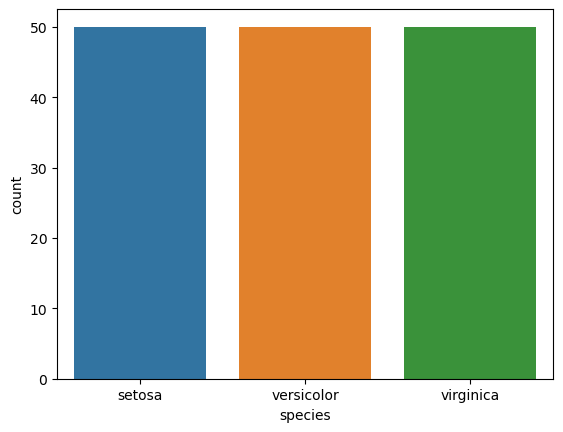

In [7]:
sns.countplot(df['species'])

<AxesSubplot:xlabel='sepal_length', ylabel='sepal_width'>

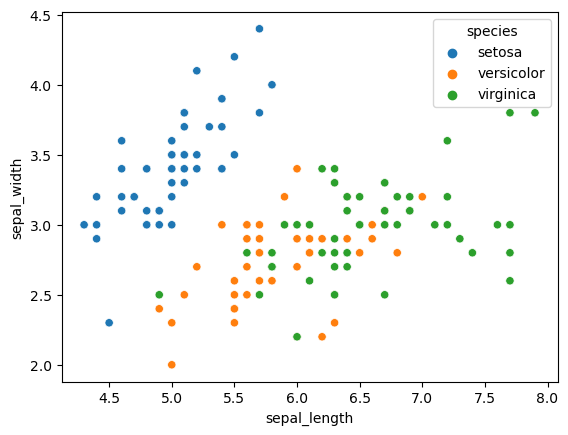

In [8]:
sns.scatterplot(x='sepal_length',y='sepal_width',data=df,hue='species')

<AxesSubplot:xlabel='petal_length', ylabel='petal_width'>

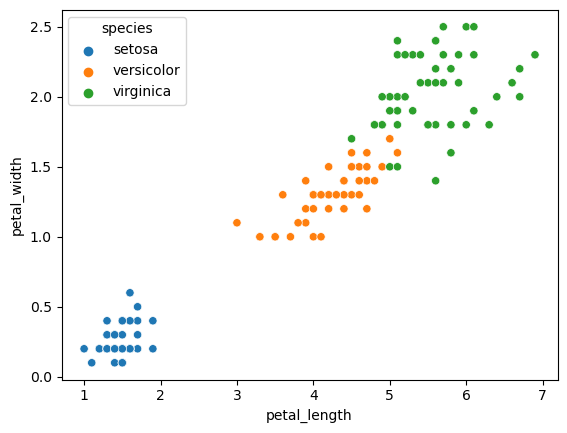

In [9]:
sns.scatterplot(x='petal_length',y='petal_width',data=df,hue='species')

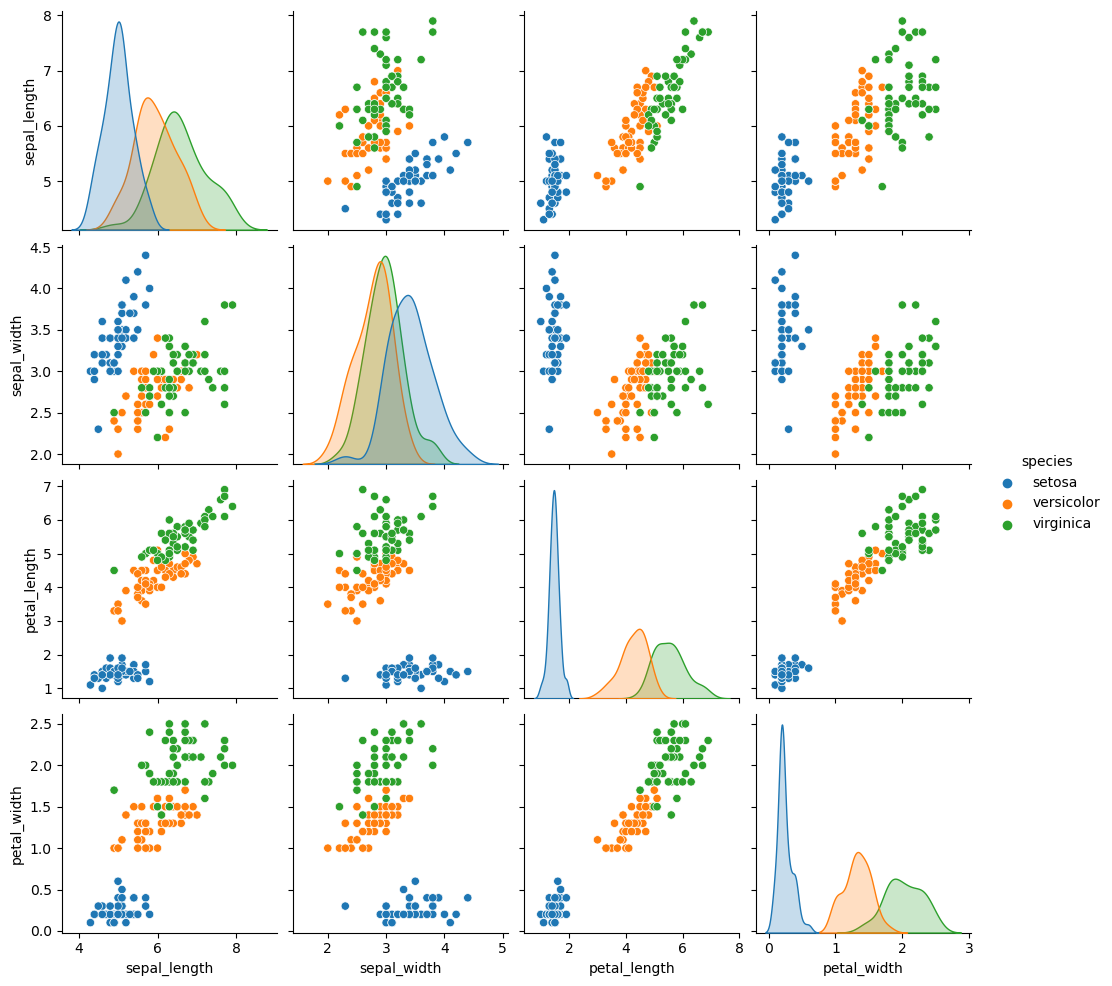

In [10]:
sns.pairplot(df,hue='species')

<AxesSubplot:>

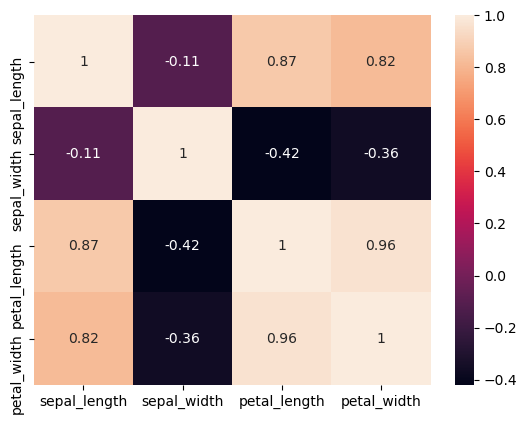

In [11]:
# ВНИМАНИЕ! В будущих версиях Scikit-Learn нужно добавлять параметр numeric_only=True
#
#sns.heatmap(df.corr(numeric_only=True),annot=True)

sns.heatmap(df.corr(),annot=True)

Вы можете находить новые типы графиков с помощью поиска в google! Например, поиск по ключевым словам "3d matplotlib scatter plot" приведёт Вас к этой странице: https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html

In [12]:
df['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

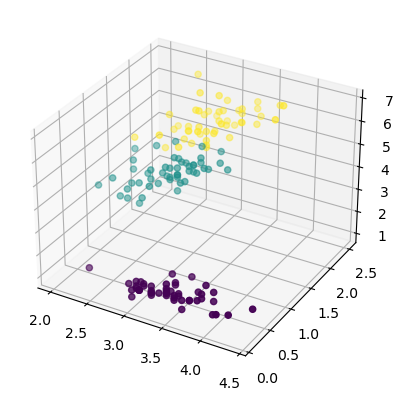

In [13]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = df['species'].map({'setosa':0, 'versicolor':1, 'virginica':2})
ax.scatter(df['sepal_width'],df['petal_width'],df['petal_length'],c=colors);

### Разбиение на обучающий и тестовый наборы данных, а также масштабирование данных (Scaling)

In [14]:
X = df.drop('species',axis=1)
y = df['species']

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

In [17]:
scaler = StandardScaler()

In [18]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Модель мультиклассовой логистической регрессии

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
from sklearn.model_selection import GridSearchCV

В зависимости от предупреждений (warning), возможно Вам придётся поменять максимальное количество итераций, или же поэкспериментировать с другими объектами solver.

In [21]:
# ВНИМАНИЕ! В будущих версиях Scikit-Learn параметр multi_class всегда принимает значение multinomial
# Чтобы реализовать логику OVR - One-vs-Rest - можно использовать класс OneVsRestClassifier:
#
#from sklearn.multiclass import OneVsRestClassifier
#log_model = LogisticRegression(solver='saga',max_iter=5000)
#log_model_ovr = OneVsRestClassifier(log_model)

log_model = LogisticRegression(solver='saga',multi_class="ovr",max_iter=5000)

### Поиск лучших значений гиперпараметров с помощью GridSearch

Основные параметры - тип penalty и значение регуляризации C.

In [22]:
# Тип Penalty
penalty = ['l1', 'l2']

# Используем логарифмически отстоящие друг от друга значения C (рекомендовано в официальной документации)
C = np.logspace(0, 4, 10)

In [23]:
# При использовании переменной log_model_ovr, то есть, для класса OneVsRestClassifier(LogisticRegression()),
# нужно будет к названиям гиперпараметров добавлять префикс estimator__ (с двумя знаками _),
# чтобы передать параметры penalty и C именно в LogisticRegression, "сквозь" OneVsRestClassifier
#
#grid_model = GridSearchCV(log_model_ovr,param_grid={'estimator__C':C,
#                                                    'estimator__penalty':penalty})

grid_model = GridSearchCV(log_model,param_grid={'C':C,
                                                'penalty':penalty})

In [24]:
grid_model.fit(scaled_X_train,y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=5000, multi_class='ovr',
                                          solver='saga'),
             param_grid={'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']})

In [25]:
grid_model.best_params_

{'C': 7.742636826811269, 'penalty': 'l1'}

### Оценка модели в задачах классификации

In [26]:
# ВНИМАНИЕ! В будущих версиях Scikit-Learn вместо plot_confusion_matrix нужно будет 
# использовать ConfusionMatrixDisplay.from_estimator или ConfusionMatrixDisplay.from_predictions 

#from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix

In [27]:
y_pred = grid_model.predict(scaled_X_test)

In [28]:
accuracy_score(y_test,y_pred)

0.9736842105263158

In [29]:
confusion_matrix(y_test,y_pred)

array([[10,  0,  0],
       [ 0, 17,  0],
       [ 0,  1, 10]])

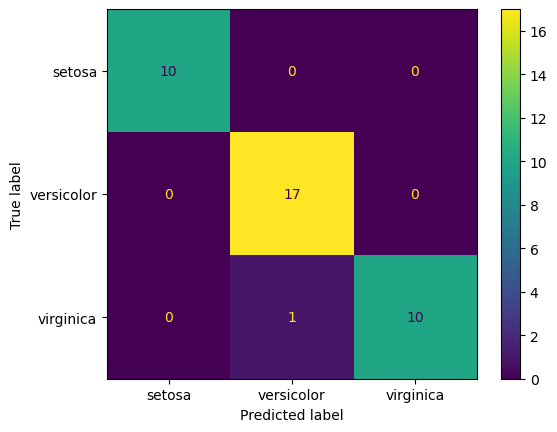

In [30]:
#ConfusionMatrixDisplay.from_estimator(grid_model,scaled_X_test,y_test)
plot_confusion_matrix(grid_model,scaled_X_test,y_test)

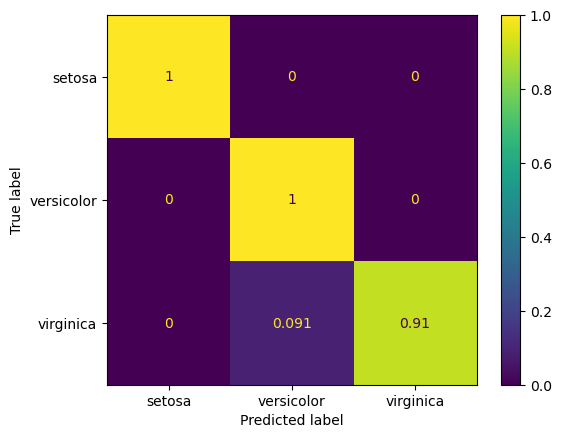

In [31]:
# Масштабированные значения, максимальное значение = 1

#ConfusionMatrixDisplay.from_estimator(grid_model,scaled_X_test,y_test,normalize='true')
plot_confusion_matrix(grid_model,scaled_X_test,y_test,normalize='true')

In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.94      1.00      0.97        17
   virginica       1.00      0.91      0.95        11

    accuracy                           0.97        38
   macro avg       0.98      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38



## Оцениваем линию кривой (curve) и область под линией (AUC - area under the curve)

**Более подробно см. в видео-лекции! В случае нескольких классов мы должны рисовать графики вручную. К счастью, в документации Scikit-learn уже есть много примеров.**

Источник: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Мы написали для Вас функцию, которая создаёт и рисует графики [ROC-кривых](https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F) для каждого класса.

In [33]:
from sklearn.metrics import roc_curve, auc

In [34]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # создаём пустые структуры
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # один раз вычисляем dummies 
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc для каждого класса
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

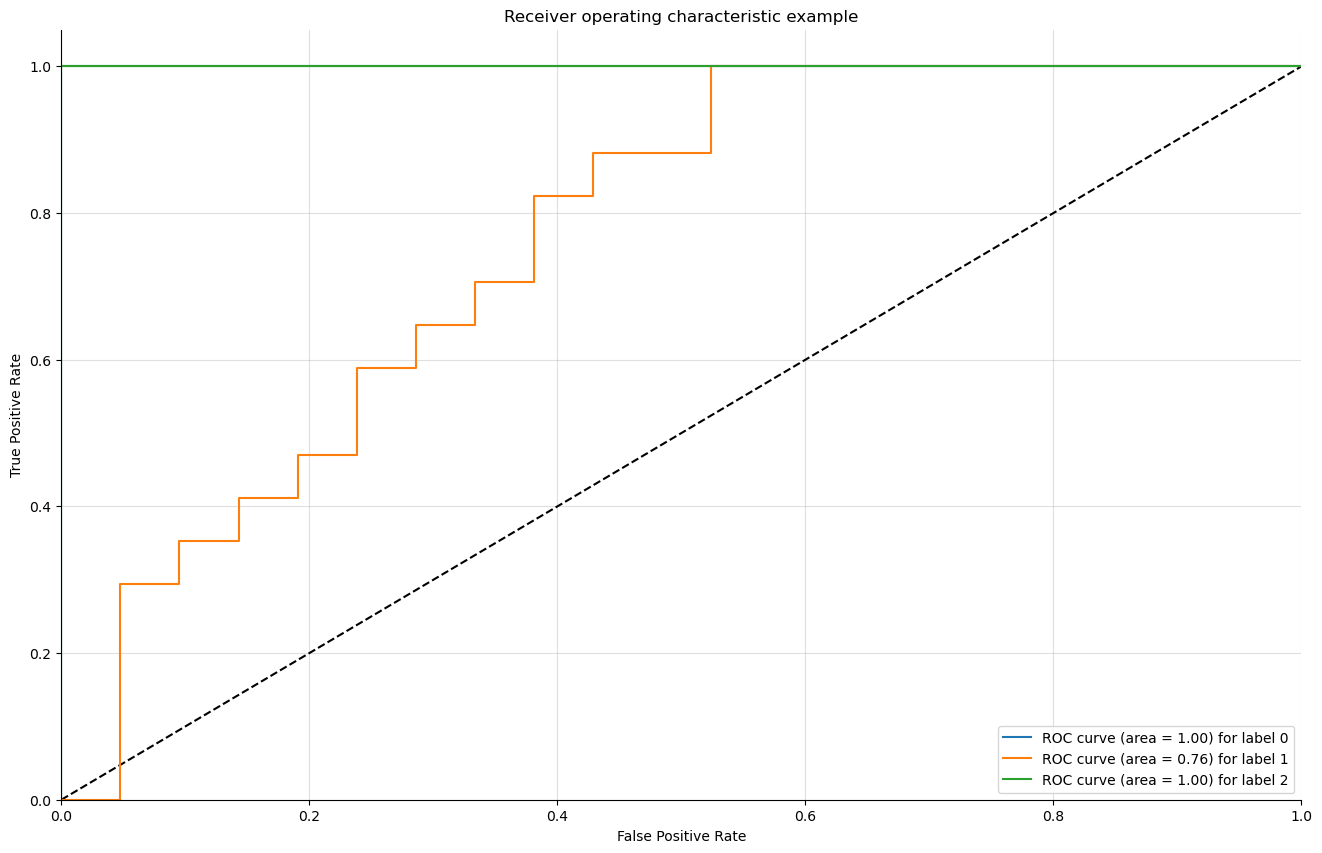

In [35]:
plot_multiclass_roc(grid_model, scaled_X_test, y_test, n_classes=3, figsize=(16, 10))

------
------